# Cylindrical Nanowire

We study transport properties through a cylindrical nanowire to reproduce orbital Josephson interference. An axial magnetic field is applied along the length of the nanowire. As a result, a vector potential $\vec{A} = A \hat{\phi}$ is present.

The Hamiltonian in indexed by two co-ordinates $\phi$ and $z$. $\phi$ denotes the azimuthal co-ordinate and $z$ the longitudinal co-ordinate of the nanowire. Each point in device is then indexed by a tuple $(\phi,z)$. 

We will use a tight-binding approach to write the device Hamiltonain. As a result, the two-coordinates $\phi$ and $z$ will be discretised into $N_{\phi}$ and $N_{z}$ points respectively. The Hamiltonian then can be expressed as:

$$ H(n_\phi,n_z;n_\phi',n_z') = 
\begin{cases}
\alpha && n_\phi = n_\phi' \ \text{and} \ n_z = n_z' \\
\beta_t^{(\dagger)} && n_\phi - n_\phi' \equiv \pm 1 \ mod(N_\phi)  \\
\beta_l && n_z - n_z' = \pm 1 
\end{cases}
$$

where $\alpha$ is the onsite element, $\beta_t$ is the transverse hopping parameter and $\beta_l$ is the logitudinal hopping parameter. Note how the cyclindrical geomtery has been handled by introducing a hopping element between the first and last points in the $\phi$ direction.

For the case of a weak magnetic field resulting in negligible Zeeman splitting and in the absence of spin-orbit coupling, the explicit forms of the matrix elements are given from the BdG Hamiltonian as follows:

\begin{align*}
\alpha &= \begin{pmatrix} 2t + 2t' l^2 && \Delta \\ \Delta* && -2t-2t' l^2\end{pmatrix} \\
\beta_t &= \begin{pmatrix} -t' l ^2 e^{i A} && 0 \\ 0 && t' l^2 e^{-i A} \end{pmatrix} \\
\beta_l &= \begin{pmatrix} -t && 0 \\ 0 && t \end{pmatrix} 
\end{align*}

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import scipy.special
import copy

I have not introduced the magnetic field at this stage to keep the calculation simple.

In [4]:
# functional creation of the Hamiltonian

def calc_H(physics):
    N_z = physics.N_z
    N_phi = physics.N_phi
    t_z = physics.t_z
    t_phi = physics.t_phi
    l = physics.l
    Delta = physics.Delta
    mu = physics.mu
    
    def calc_H_element(e1,e2):
        (z1,phi1) = e1
        (z2,phi2) = e2
        # onsite element
        if z1 == z2 and phi1 == phi2:
            diag_ele = 2*t_z + 2*t_phi*l**2 - mu
            return np.array([[diag_ele,Delta],[np.conj(Delta),-np.conj(diag_ele)]])
        # z hopping
        elif abs(z1-z2) == 1 and phi1 == phi2:
            return np.array([[-t_z,0],[0,t_z]])
        # phi hopping
        elif (abs(phi1-phi2) == 1 or abs(phi1-phi2) == N_phi-1)and z1 == z2:
            return np.array([[-t_phi*l**2,0],[0,np.conj(t_phi)*l**2]])
        else:
            return np.array([[0,0],[0,0]])
        # the basis is given by (n_z,n_phi) where n_z = 0,..,N_z-1, n_phi = 0,...,N_phi-1
    basis = list(itertools.product(range(N_z),range(N_phi)))
    H = [calc_H_element(e1,e2) for e1 in basis for e2 in basis]
    N = (N_phi*N_z)

    H_ar = np.array(H,dtype=np.complex64).reshape((N,N,2,2))
    H_mat = np.array([H_ar[x,:,y,:].flatten() for x in range(H_ar.shape[0]) for y in range(H_ar.shape[2])])\
    .flatten().reshape(2*N,2*N)

    return H_mat
    
    
    
    

Once the function creating the Hamiltonian has been defined, I follow the standard NEGF results to calculate current (I) as a function of E.

In [18]:
 def current_E(E,physics):
    N_phi = physics.N_phi
    N_z =  physics.N_z
    
    eta = physics.eta
    kT = physics.kT
    mu_1 = physics.mu_1
    mu_2 = physics.mu_2
    mu = 0.5*(mu_1 + mu_2)
    Delta1 = physics.Delta1
    Delta2 = physics.Delta2
    
    t_z = physics.t_z
    t_phi = physics.t_phi
    l = physics.l
    
    # create the physical paramters dictionaries to create the respective Hamiltonians for S1-N-S2
    physical_parameters_N = Physics()
    physical_parameters_N.N_z = N_z
    physical_parameters_N.N_phi = N_phi
    physical_parameters_N.Delta = 0.0
    physical_parameters_N.t_z = t_z 
    physical_parameters_N.t_phi = t_phi 
    physical_parameters_N.l = l 
    physical_parameters_N.mu = mu
    
    
    physical_parameters_S1 = Physics()
    physical_parameters_S1.N_z = N_z
    physical_parameters_S1.N_phi = N_phi
    physical_parameters_S1.Delta = Delta1
    physical_parameters_S1.t_z = t_z 
    physical_parameters_S1.t_phi = t_phi 
    physical_parameters_S1.l = l 
    physical_parameters_S1.mu = mu_1
    
    physical_parameters_S2 = Physics()
    physical_parameters_S2.N_z = N_z
    physical_parameters_S2.N_phi = N_phi
    physical_parameters_S2.Delta = Delta2
    physical_parameters_S2.t_z = t_z 
    physical_parameters_S2.t_phi = t_phi 
    physical_parameters_S2.l = l 
    physical_parameters_S2.mu = mu_2
    
    def surface_g(E,physical_parameters):
        # create a dummy Hamiltonian with two layers to get the hopping element beta and the layer element alpha
        
        dummy_params = Physics()
        dummy_params = physical_parameters
        dummy_params.N_z = 2
        
        H_mat = calc_H(dummy_params)

        N_dof_lat = N_phi*2

        alpha = H_mat[:N_dof_lat,:N_dof_lat]
        beta = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]

        err = 1.0
        iter_count = 0
        iter_limit = 100000
        err_limit = 1e-6

        g = np.linalg.inv((E + 1j*eta)*np.eye(alpha.shape[0]) - alpha)
        g_old = np.linalg.inv((E + 1j*eta)*np.eye(alpha.shape[0]) - alpha)
        # iterate over iter_limit iterations or until err < err_limit
        for i in range(iter_limit):
            g = np.linalg.inv((E + 1j*eta)*np.eye(alpha.shape[0]) - alpha - np.dot(np.dot(np.conj(beta.T),g),beta))
            g = 0.5*(g + g_old)

            err = np.linalg.norm(g-g_old)/np.sqrt(np.linalg.norm(g)*np.linalg.norm(g_old))
            g_old = g
            if(err < err_limit):
                #print("Finished at",i,"Error :",err)
                break;
            if(i == (iter_limit - 1)):
                print("iter_limit hit in calculation of surface_g",err)
        return g
    
    g_1 = surface_g(E,physical_parameters_S1)
    g_2 = surface_g(E,physical_parameters_S2)
    
    H_mat = calc_H(physical_parameters_N)
    
    #number of dof in a layer
    N_dof_lat = N_phi*2
    # the hopping element between layers
    beta_layer = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]
    
    # the only non-zero elements in sigma
    sigma_mini_1 = np.dot(np.dot(np.conj(beta_layer.T),g_1),beta_layer)
    sigma_mini_2 = np.dot(np.dot(np.conj(beta_layer.T),g_2),beta_layer)
    
    sigma_1 = np.zeros(H_mat.shape,dtype=np.complex64)
    sigma_1[:N_dof_lat,:N_dof_lat] = sigma_mini_1
    gamma_1 = 1j*(sigma_1 - np.conj(sigma_1).T)
    
    sigma_2 = np.zeros(H_mat.shape,dtype=np.complex64)
    sigma_2[-N_dof_lat:,-N_dof_lat:] = sigma_mini_2
    gamma_2 = 1j*(sigma_2 - np.conj(sigma_2).T)    
    
    def fermi(E,kT):
        return scipy.special.expit(-E/kT)
    
    def generate_fermi_matrix(E,mu,kT):
        return np.array([[fermi(E - mu,kT),0],[0,fermi(E + mu,kT)]])
        
    F1 = np.kron(np.eye(N_phi*N_z),generate_fermi_matrix(E,mu_1-mu,kT))
    F2 = np.kron(np.eye(N_phi*N_z),generate_fermi_matrix(E,mu_2-mu,kT))
    
    sigma_in = np.dot(gamma_1,F1) + np.dot(gamma_2,F2)

    G = np.linalg.inv((E + 1j*eta)*np.eye(H_mat.shape[0]) - H_mat - sigma_1 - sigma_2)
    
    A = 1j*(G - np.conj(G).T)
    
    G_n = np.dot(np.dot(G,sigma_in),np.conj(G).T)
    
    #I_mat = 1j*(np.dot(G_n[:N_dof_lat,N_dof_lat:2*N_dof_lat],beta_layer) \
    #        - np.dot(G_n[N_dof_lat:2*N_dof_lat,:N_dof_lat],beta_layer))
    I_mat = 1j*(np.dot(H_mat,G_n) - np.dot(G_n,H_mat))
    # current = electron current - hole current
    I = np.real(I_mat[0,0]-I_mat[1,1])
    return I

class Physics:
    def __init__(self):
        return



In [64]:
physics = Physics()

phi = np.pi/4

physics.N_z = 2
physics.N_phi = 4
physics.t_z = 0.5
physics.t_phi = 0.5*np.exp(1e-3j)
physics.l = 1
physics.Delta1 = 1e-2
physics.Delta2 = 1e-2*np.exp(1j*phi)
physics.mu_1 = 2
physics.mu_2 = 2
physics.eta = 1e-6
physics.kT = 1e-5

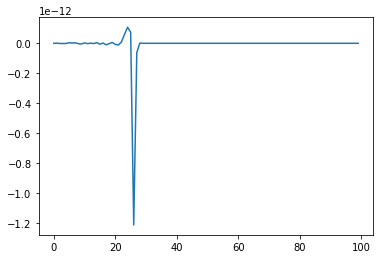

In [67]:
I = [current_E(E,physics) for E in np.linspace(-2*physics.Delta1,2*physics.Delta1,100)]
plt.plot(I)

/usr/local/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


10774.514533996582


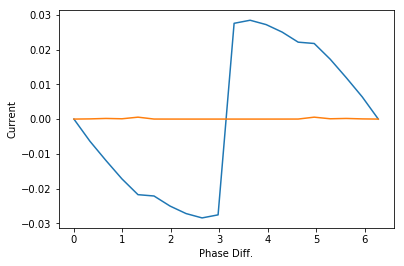

In [68]:
import scipy.integrate
def calc_I_phi(x,phi): 
    x.Delta2 = abs(x.Delta2)*np.exp(1j*phi)
    return scipy.integrate.quad(lambda y : current_E(y,x),-2e-2,2e-2,epsrel=1e-4)
import time
st = time.time()
I_phi = [calc_I_phi(physics,phi) for phi in np.linspace(0,2*np.pi,20)]
plt.plot(np.linspace(0,2*np.pi,len(I_phi)),I_phi)
plt.xlabel('Phase Diff.')
plt.ylabel('Current')
print(time.time()-st)

In [69]:
physics.Delta2

(-0.0026647381369003537+0.009638421585599433j)

In [71]:
1e-2*np.exp(1j*np.pi/2)

(6.123233995736766e-19+0.01j)